## Load Libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import sklearn.linear_model as sk_lm
import sklearn.metrics as sk_metrics
%matplotlib inline

## Basic NumPy Version of Gradient Descent.

In [2]:
# Cost function: x^2
def J(x):
    return x * x

# Gradient of x^2 = 2*x
def J_grad(x):
    return 2 * x

# Creates datapoints to generate a gradient slope line
def grad_graph_helper(fn, mid, error, delta):
    x = np.linspace(mid-delta, mid+delta)
    y = error - (mid - x) * fn(mid)
    return x, y

# Plots x^2 with a given gradient slope and annotations 
def make_plot(ax, x, error, grad):
    grad_x, grad_y = grad_graph_helper(J_grad, x, error, 1)
    xs = np.linspace(-10, 10, 300)
    Js = J(xs)
    
    ax.set_xlabel('x'); ax.set_ylabel('J'); ax.grid(True)

    ax.plot(xs, Js)
    ax.plot(grad_x, grad_y, c='g', linewidth=2)
    ax.scatter(x, error, c='r', marker='s', s=50, zorder=6)
    
    if grad < 0:
        text_fill, x_add, error_add = ("< 0", "right"), 2, 10
    else:
        text_fill, x_add, error_add = ("> 0", "left"), -9, 10
    ax.annotate("Grad is {}; move to the {}".format(*text_fill),
                [x, error], [x+x_add, error+error_add],
                arrowprops={'arrowstyle': '->'})

def descend(x, learning_rate, steps=50, graph_steps=[0, 5, 15, 49]):
    x = float(x)
    fig, axes = plt.subplots(ncols=1, 
                             nrows=len(graph_steps), 
                             figsize=(12, 4*len(graph_steps)))
    axes = iter(axes)
    for step in range(steps):
        error, grad = J(x), J_grad(x)
        if step in graph_steps:
            ax = next(axes)
            ax.set_title('Step: {}'.format(step))
            make_plot(ax, x, error, grad)
        x -= learning_rate * grad
    plt.tight_layout()

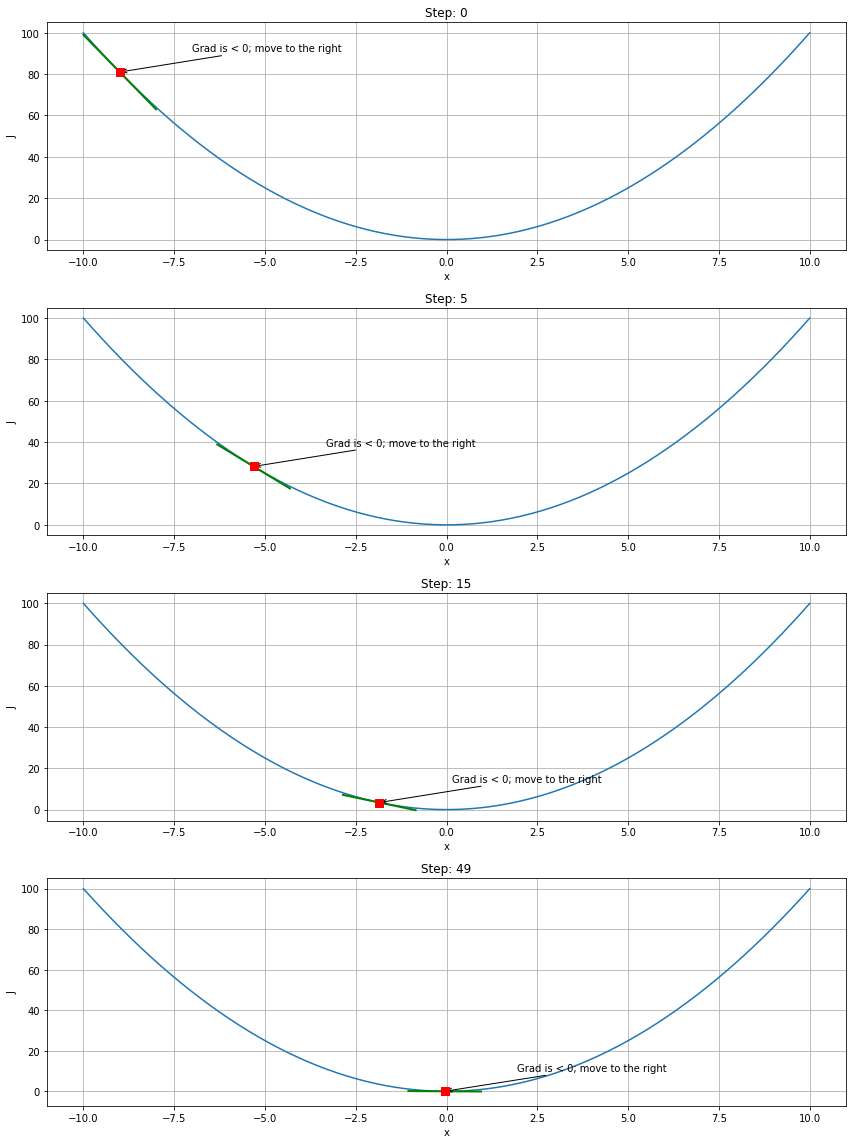

In [3]:
# Starting from the left side
descend(-9.0, 0.05)

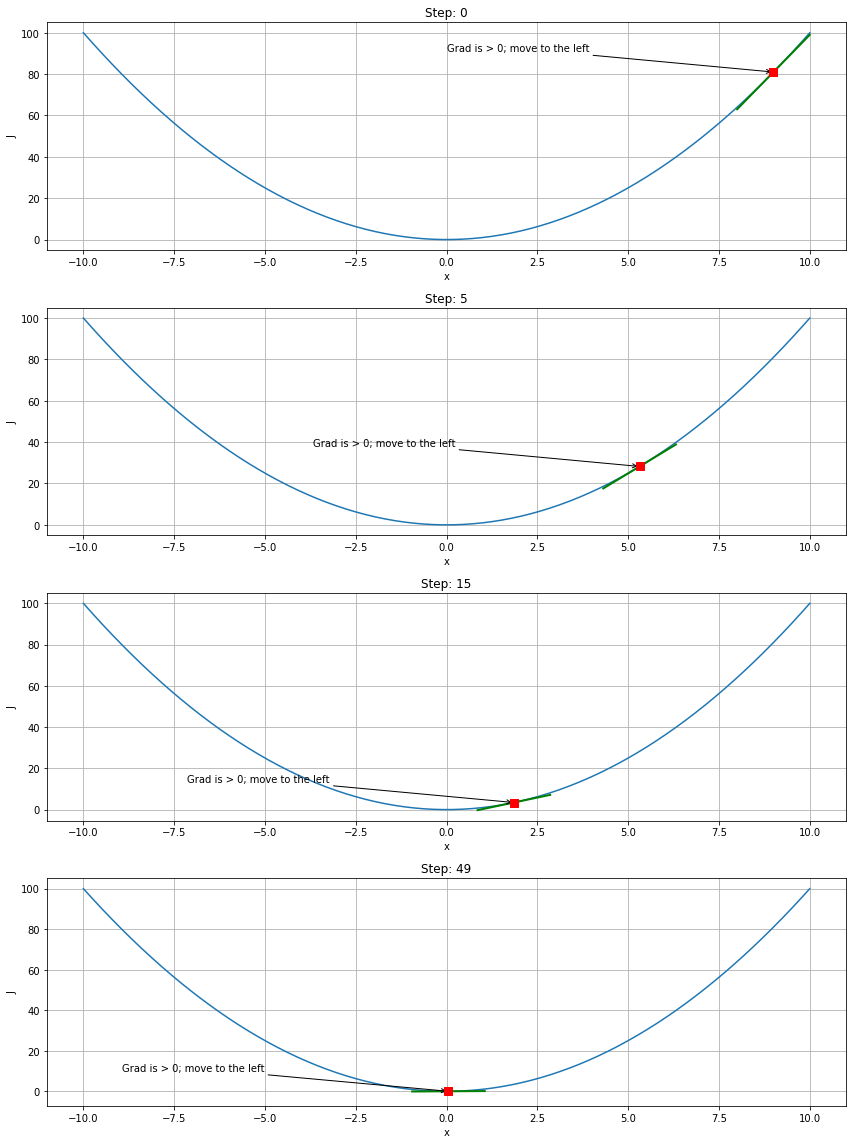

In [4]:
# Starting from the right side
descend(9.0, 0.05)

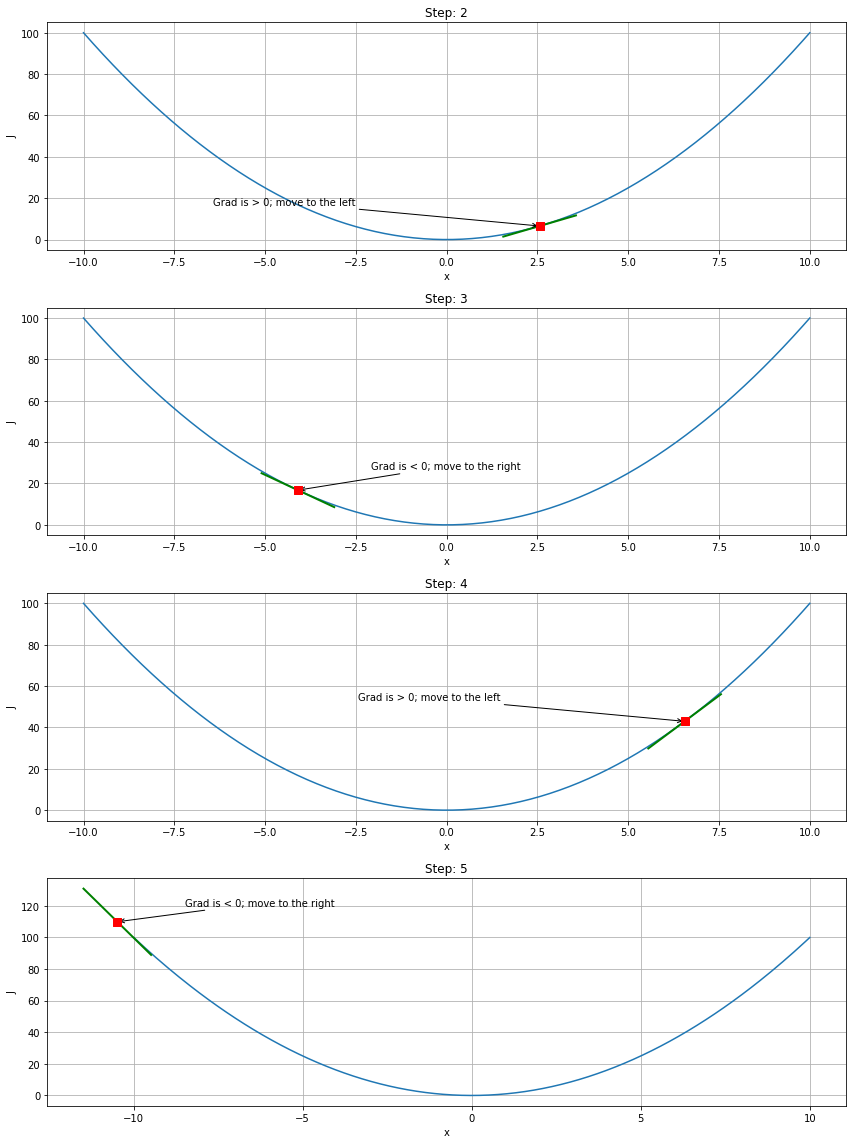

In [5]:
# What happens if learning rate is too high
descend(1.0, 1.3, 6, [2, 3, 4, 5])

## Gradient Descent with TensorFlow

Let's create some data to learn from.  We're going to end up fitting a line to this data using linear regression. The following code creates scatter data that is roughly along the line $y=3x+2$. This is in the classic point-slope form of a line $y=mx+b$, but to prepare us for more general formulations, we'll write it as $y=wx+b$ ($w$ for *weight*).

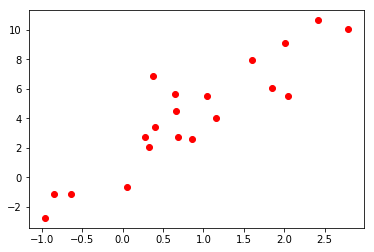

In [6]:
x = np.random.normal(loc=1, scale=1, size=[20])
epsilon = np.random.normal(loc=0, scale=1.5, size=[20])
y = (3 * x) + 2 + epsilon
plt.scatter(x,y,c='r');

Now, we can create a simple linear model that can learn to fit the previous data. We will:
  1.  Create the model
  2.  Run the model

#### Create Graph for the Linear Regression Model

In [7]:
linreg_graph = tf.Graph()

with linreg_graph.as_default():
    with tf.name_scope('inputs'):
        x_placeholder = tf.placeholder(tf.float32, [None], name='x')
        y_placeholder = tf.placeholder(tf.float32, [None], name='y')
        learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    with tf.name_scope('model'):
        w = tf.Variable(tf.truncated_normal([]), name='w') # random values from a truncated normal distribution
        b = tf.Variable(tf.constant(0, dtype=tf.float32), name='b')
        y_hat = tf.multiply(w, x_placeholder) + b
    
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.square(y_hat - y_placeholder), name='MSE')
    
    with tf.name_scope('train'):
        opt = tf.train.GradientDescentOptimizer
        train = opt(learning_rate).minimize(loss)
    
    with tf.name_scope('global_step'):
        global_step = tf.Variable(0, trainable=False, name='global_step')
        inc_step = tf.assign_add(global_step, 1, name='inc_step')
    
    with tf.name_scope('helpers'):
        init = tf.global_variables_initializer()

#### Run the Model

We start off by initializing the Variables:

In [8]:
session = tf.Session(graph=linreg_graph)
session.run(init) # initialize variables

`train_dict` and `test_dict` will be fed into `run` calls.

In [9]:
# "true" model:  y = true_w * x + true_b
true_w, true_b = 3, 2

# create training data and make a feeder dict
x_train = np.random.uniform(-5, 5, size=[20])
epsilon = np.random.normal(loc=0, scale=1.5, size=[20])
y_train = (true_w * x_train) + true_b + epsilon
train_dict = {x_placeholder: x_train,
              y_placeholder: y_train,
              learning_rate: 0.05}

# some points to evaluate at 
# also serve to reconstruct fitted line below
x_test = np.array([-5.0, 5.0])
test_dict = {x_placeholder: x_test}

Finally, the "main" running of the model. We have a loop that performs training at every pass. Then, at selected steps, we also keep track of some results of testing on our evaluation `x_test` data.  In the `y_test=` line, we *do not* fetch the value of the `train` Operation.  Thus, we *do not* update the weights of our model.  Put another way, we only train when we fetch `train`.

In [10]:
snapshots = []
print("{:2} {:^6s}".format("i", "MSE"))

for i in range(50):    
    J, w_est, b_est, step, _ = session.run([loss, w, b, inc_step, train], 
                                           feed_dict=train_dict)
    if not i % 5:
        print("{:<2d} {:>6.3f}".format(step, J))

    if step in [0, 1, 4, 10, 49]:
        y_test = session.run(y_hat, feed_dict=test_dict)
        snapshots.append((i, y_test, w_est, b_est, J))    

i   MSE  
1  156.226
6   1.874
11  1.403
16  1.221
21  1.151
26  1.125
31  1.114
36  1.110
41  1.109
46  1.108


## Visualize the Progression of the Estimates

In [11]:
# Get the final W and b values
final_w_est, final_b_est = session.run([w, b])
_, _, w_ests, b_ests, losses = zip(*snapshots)

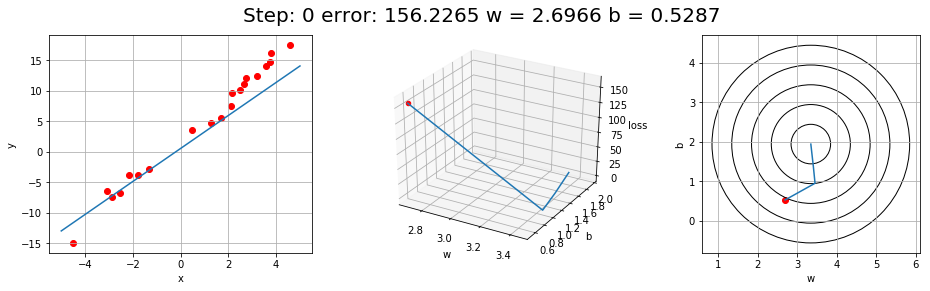

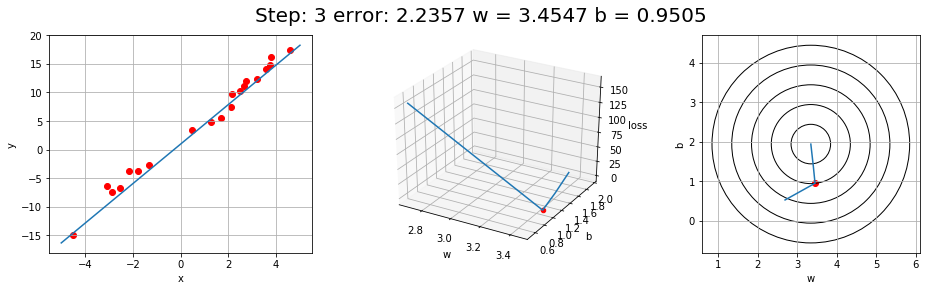

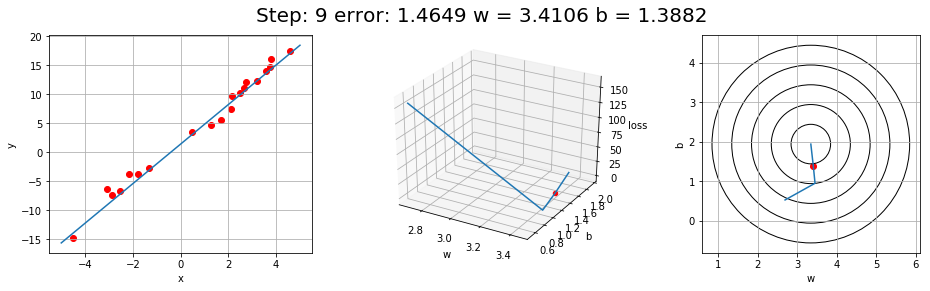

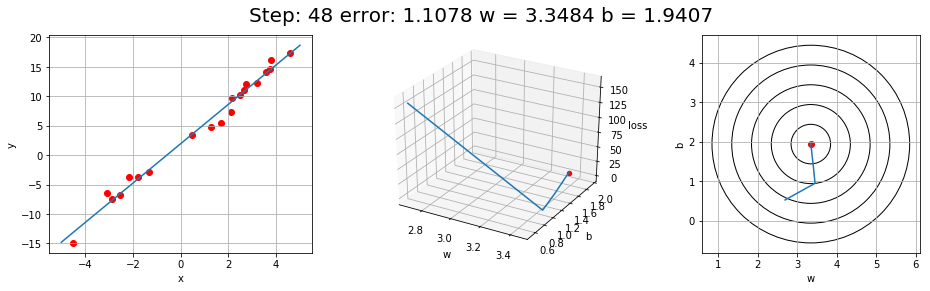

In [12]:
for i, snapshot in enumerate(snapshots):
    # extract needed components for current snapshot
    step, y_test, curr_w_est, curr_b_est, curr_loss = snapshot

    # setup outer figure
    fig = plt.figure(figsize=(16,4))
    title_fmt = 'Step: {} error: {:0.4f} w = {:0.4f} b = {:0.4f}'
    title_string = title_fmt.format(step, curr_loss, 
                                    curr_w_est, curr_b_est)
    fig.suptitle(title_string, size=20)

    # Scatter plot of data with predicted line
    ax = plt.subplot(131)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.grid(True)
    ax.scatter(x_train, y_train, c='r')
    ax.plot(x_test, y_test) # both curr train->test and estimated line

    # 3D view of estimated w and b values against loss
    ax = plt.subplot(132, projection='3d')
    ax.set_xlabel('w'); ax.set_ylabel('b'); ax.set_zlabel('loss')
    ax.plot(w_ests, b_ests, losses)
    ax.scatter(curr_w_est, curr_b_est, curr_loss, c='r')
    
    # Overhead view of approximate error curves
    ax = plt.subplot(133)
    ax.set_xlabel('w'); ax.set_ylabel('b'); ax.grid(True)
    for i in range(1,6):
        circ = mpl.patches.Circle([final_w_est, final_b_est], 
                                  .5 * i, fill=False)
        ax.add_patch(circ)
        
    ax.plot(w_ests, b_ests)                   # the path of w/b estimates
    ax.scatter(curr_w_est, curr_b_est, c='r') # really just one point
    ax.set_aspect('equal')

In [13]:
# scikit learn's estimates
model = sk_lm.LinearRegression()
model.fit(np.reshape(x_train,[20,1]), y_train)
print('sk linreg w: {:5.3f} b: {:5.3f}'.format(model.coef_[0], 
                                                model.intercept_))

# compared with our estimates
print('our tflr  w: {:5.3f} b: {:5.3f}'.format(final_w_est, 
                                                final_b_est))

sk linreg w: 3.347 b: 1.954
our tflr  w: 3.348 b: 1.942


## Examining gradients

The code below gets the gradient of the `tf.square()` Operation, which we expect to return `2*input`, as the derivative of $x^2$ is $2x$

In [14]:
grad_graph = tf.Graph()
with grad_graph.as_default():
    # A dummy variable that we can play around with to get different values
    a = tf.Variable(3.0)

    # The operation we want to get the derivative of
    # b = a**2; deriv(b) = deriv(a**2) = 2a 
    # eval @ a=3 gives deriv(b wrt a) = 6
    b = tf.square(a) 

    # Create an Optimizer
    opt = tf.train.GradientDescentOptimizer(0.05)

    # Compute the gradient of `b` with respect to `a`
    grads = opt.compute_gradients(b, [a])
    init = tf.global_variables_initializer()

    
with tf.Session(graph=grad_graph) as session:
    session.run(init)
    print(session.run(grads))

[(6.0, 3.0)]


## Some Realistic Data

We'll use the UCI Housing dataset for this example, where the target is to predict the median value of homes in neighborhoods of Boston. The code below downloads the dataset and information files.

In [15]:
base_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/'
data_suf = 'housing/housing.data'
url = base_url + data_suf

In [16]:
# manually extracted from housing.names
housing_names = ('CRIM,ZN,INDUS,CHAS,NOX,'
                 'RM,AGE,DIS,RAD,TAX,'
                 'PTRATIO,B,LSTAT,MEDV').split(',')

house_data = pd.read_table(url, sep='\s+', names=housing_names)
house_data.head()  

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Make a training and test set.

In [17]:
# why not just use sklearn shuffle split?  
# skl uses fancy indexing which triggers copies
# these are continguous blocks, so there is no copy needed
def df_train_test_blocks(df, pct):
    num_train_examples = int(len(df) * pct)
    return df.iloc[:num_train_examples], df.iloc[num_train_examples:]
my_train, my_test = df_train_test_blocks(house_data, .8)
my_train.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
399,9.91655,0.0,18.1,0,0.693,5.852,77.8,1.5004,24,666.0,20.2,338.16,29.97,6.3
400,25.04610,0.0,18.1,0,0.693,5.987,100.0,1.5888,24,666.0,20.2,396.90,26.77,5.6
401,14.23620,0.0,18.1,0,0.693,6.343,100.0,1.5741,24,666.0,20.2,396.90,20.32,7.2
402,9.59571,0.0,18.1,0,0.693,6.404,100.0,1.6390,24,666.0,20.2,376.11,20.31,12.1
403,24.80170,0.0,18.1,0,0.693,5.349,96.0,1.7028,24,666.0,20.2,396.90,19.77,8.3


Now that we have some more realistic data and we've created train/test subsets of the data, let's do some (linear regression) modeling!  Let's pick a few features (number of rooms, age, and tax rate) and (1) look at some descriptive statistics for those features and (2) look at the pairwise interactions between those features and median value with some scatter plots.  These graphs are only for the training data!

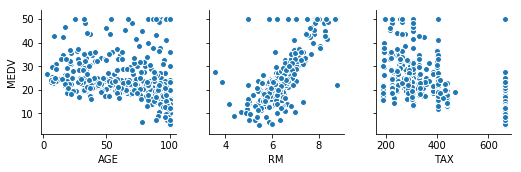

In [18]:
my_ftrs = my_train[['MEDV', 'AGE', 'RM', 'TAX']]
my_ftrs.describe()

import seaborn as sns
sns.pairplot(my_ftrs, x_vars=['AGE', 'RM', 'TAX'], y_vars=['MEDV']);

## Linear Regression Models with scikit_learn

Let's make three regression models between these variables (individually) and median price.  So, our three models will be (where $y \sim x$ is read as "y is modeled on x", this notation comes from R): 
  1. $price \sim  age$
  1. $price \sim rooms$
  3. $price \sim tax$
  
In turn, we'll use the training data to build each of these models (using scikit_learn) and then we'll graph the fit line against the training data.  We'll also compute the $R^2$ statistic for the fit against the training data ($R^2$ is SKL's default scorer for LinearRegression).

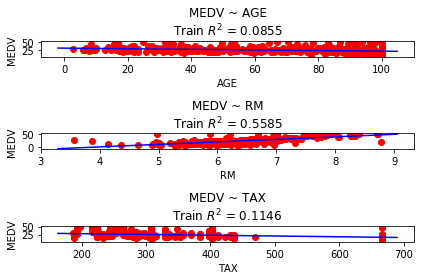

In [19]:
model_on = ['AGE', 'RM', 'TAX']
models = {}
fig, axes = plt.subplots(3,1)
for ax, ftr in zip(axes, model_on):
    models[ftr] = sk_lm.LinearRegression().fit(my_ftrs[[ftr]], 
                                               my_ftrs[['MEDV']])
    ax.scatter(my_ftrs[[ftr]], my_ftrs[['MEDV']], c='r')

    x_vals = np.array(ax.get_xlim()) # great trick to get min/max x
    y_vals = models[ftr].intercept_ + models[ftr].coef_[0] * x_vals
    ax.plot(x_vals, y_vals, c='b')

    train_r_squared = models[ftr].score(my_ftrs[[ftr]], 
                                       my_ftrs[['MEDV']])
    
    ax.set_xlabel(ftr); ax.set_ylabel('MEDV')
    ax.set_title("MEDV ~ {}\nTrain $R^2$ = {:5.4f}".format(ftr, train_r_squared))

plt.tight_layout()

Now, typically, we don't expect single variable to fully capture complex phenomena. So, let's build two more models:
  
  1. $price \sim age + room + tax$
  2. $price \sim room + tax$
  
Here, adding something to the right hand side of the model means it is an additional feature/variable in our model.

In [20]:
models = (('Full', ['AGE', 'RM', 'TAX']),
          ('Room, Tax', ['RM', 'TAX']))
target = 'MEDV'

for model_name, predictors in models:
    fit = sk_lm.LinearRegression().fit(my_ftrs[predictors],
                                       my_ftrs[target])
    r2 = fit.score(my_ftrs[predictors], my_ftrs[target])
    print("{:10} Train R^2: {:5.4f}".format(model_name, r2))

Full       Train R^2: 0.5780
Room, Tax  Train R^2: 0.5717


## Housing Data Modeling with TensorFlow

The room and tax model seems to do fairly well (at least compared to all three variables).  So, let's recreate that with TensorFlow.  We are going to add one layer of abstraction to our model.  You'll notice that the scikit_learn `Linear Regression` has three steps:

  1.  create it
  2.  fit it
  3.  predict/score with it
  
These are very similar to the way a TensorFlow model is typically used.  We will implement a simple `class` which has three methods:

  1. `__init__`:  create the TensorFlow Graph
  2. `fit`:  read in training data and optimize to it
  3. `predict`:  read in testing data and give our best guesses (and possibly other results)

In [21]:
class TF_GD_LinearRegression:
    # WARNING: 
    # s instead of self is non-standard, for abbreviation purposes
    def __init__(s):  
        graph = tf.Graph()
        with graph.as_default():
            
            with tf.name_scope('inputs'):
                s.x_placeholder = tf.placeholder(tf.float32, [None, 2], name='x')
                s.y_placeholder = tf.placeholder(tf.float32, [None], name='y')
                s.learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
            
            with tf.name_scope('model'):
                s.w = tf.Variable(tf.truncated_normal([2, 1]), name='w')
                s.b = tf.Variable(0.0, name='b')
                s.y_hat = tf.matmul(s.x_placeholder, s.w) + s.b
            
            with tf.name_scope('loss'):
                s.loss = tf.reduce_mean(tf.square(s.y_hat - s.y_placeholder), name='MSE')
            
            with tf.name_scope('train'):
                s.train = tf.train.GradientDescentOptimizer(s.learning_rate).minimize(s.loss)
            
            s.init = tf.global_variables_initializer()
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
    
    def fit(s, train_dict):
        return s.session.run([s.loss, s.w, s.b, s.train], feed_dict=train_dict)

    def predict(s, test_dict):
        return s.session.run(s.y_hat, feed_dict=test_dict)

In [22]:
# read in the data (just a reminder from what was above)
print("Data file:", url)
print("Names:", housing_names)
my_data = pd.read_table(url, sep='\s+', names=housing_names)

# select out some columns of interest and then train/test split it
my_ftrs = my_data[['MEDV', 'AGE', 'RM', 'TAX']]
my_train, my_test = df_train_test_blocks(my_ftrs, .8)

# our ftrs to use for this particular model
predictors = ['RM', 'TAX']
target     = 'MEDV' # output tensor (y_placeholder) expects 1D tensor, not 2D - so no list

# feeding data to TensorFlow, might not be happy with DataFrames
# so we access the underlying NumPy data directly with .values
my_train_x = my_train[predictors].values
my_train_y = my_train[target].values
my_test_x  = my_test[predictors].values
my_test_y  = my_test[target].values

Data file: http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Names: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [23]:
model = TF_GD_LinearRegression()

# model.x_placeholder becomes s.x_placeholder in TF_GD_LinearRegression above
train_dict = {model.x_placeholder: my_train_x,
              model.y_placeholder: my_train_y,
              model.learning_rate: 0.000001}

test_dict = {model.x_placeholder: my_test_x}

In [24]:
print("{:3} {:>15s}".format("i", "Training MSE"))
snapshots = []

for epoch in range(100000):
    loss, w, b, _ = model.fit(train_dict)
    if epoch % 10000 == 0:
        print("{:<3d} {:>15.3f}".format(epoch, loss))
        y_test = model.predict(test_dict)
        snapshots.append((epoch, y_test, w, b, loss))
print("{:<2d} {:>15.3f}".format(epoch, loss))

i      Training MSE
0         19825.201
10000         146.175
20000         133.578
30000         123.845
40000         116.325
50000         110.515
60000         106.026
70000         102.557
80000          99.877
90000          97.806
99999          96.205


In [25]:
# final trained model
y_test = model.predict(test_dict)
tf_roomtax_mse = sk_metrics.mean_squared_error(y_test[:,0], my_test_y)

print("tensorflow gd linear regression model")
print("price ~ room + tax")
print("w: {} b: {}".format(w[:,0],b))
print("Test MSE:", tf_roomtax_mse)

tensorflow gd linear regression model
price ~ room + tax
w: [2.2502196  0.02426221] b: 0.36361584067344666
Test MSE: 217.05402075427688


In [26]:
# and for comparison, with the scikit learn room+tax model
skl_fit = sk_lm.LinearRegression().fit(my_train_x, my_train_y)
skl_roomtax_mse = sk_metrics.mean_squared_error(skl_fit.predict(my_test_x), my_test_y)

print("sklearn linear regression model:")
print("price ~ room + tax")
print("w: {} b: {}".format(skl_fit.coef_, skl_fit.intercept_))
print("Test MSE: {}".format(skl_roomtax_mse))

sklearn linear regression model:
price ~ room + tax
w: [ 8.98769653e+00 -8.49948244e-03] b: -29.744758512034203
Test MSE: 49.086099990017026


## Wine Data Modeling with TensorFlow

Load data.

In [27]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
wine_data = pd.read_csv(url, sep=';', dtype=np.float32)
col_names = [feature.replace(' ', '_') for feature in list(wine_data)]
wine_data.columns = col_names
wine_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.700001,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.600000,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.900000,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


Split data into training and test set.

In [28]:
def split(df, features, target):
    df = df.reindex(np.random.permutation(df.index))
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import normalize
    x = normalize(df[features])
    y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    return x_train, x_test, y_train, y_test
    
features = ['fixed_acidity', 'chlorides', 'pH', 'alcohol', 'citric_acid', 'total_sulfur_dioxide']
target = 'quality'
x_train, x_test, y_train, y_test = split(wine_data, features, target)

Linear regression with selected features.

In [29]:
reg = sk_lm.LinearRegression().fit(x_train, y_train)
mse = sk_metrics.mean_squared_error(reg.predict(x_test), y_test)
print('MSE:', mse)

MSE: 0.6576080670411616


In [30]:
class TF_GD_LinearRegression:
    def __init__(s, num_feat):  
        graph = tf.Graph()
        s.num_feat = num_feat
        with graph.as_default():
            with tf.name_scope('inputs'):
                s.x_placeholder = tf.placeholder(tf.float32, [None, s.num_feat], name='x')
                s.y_placeholder = tf.placeholder(tf.float32, [None], name='y')
                s.learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
            with tf.name_scope('model'):
                s.w = tf.Variable(tf.truncated_normal([s.num_feat, 1]), name='w')
                s.b = tf.Variable(0.0, name='b')
                s.y_hat = tf.matmul(s.x_placeholder, s.w) + s.b
            
            with tf.name_scope('loss'):
                s.loss = tf.reduce_mean(tf.square(s.y_hat - s.y_placeholder), name='MSE')
            
            with tf.name_scope('train'):
                s.train = tf.train.GradientDescentOptimizer(s.learning_rate).minimize(s.loss)
            
            s.init = tf.global_variables_initializer()
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
    
    def fit(s, train_dict):
        return s.session.run([s.loss, s.w, s.b, s.train], feed_dict=train_dict)

    def predict(s, test_dict):
        return s.session.run(s.y_hat, feed_dict=test_dict)

In [31]:
model2 = TF_GD_LinearRegression(x_train.shape[1])

train_dict = {model2.x_placeholder: x_train,
              model2.y_placeholder: y_train,
              model2.learning_rate: 0.001}

test_dict = {model2.x_placeholder: x_test}

In [32]:
print("{:3} {:>15s}".format("i", "Training MSE"))
snapshots = []

for epoch in range(1000):
    loss, w, b, _ = model2.fit(train_dict)
    if epoch % 100 == 0:
        print("{:<3d} {:>15.3f}".format(epoch, loss))
        y_temp = model2.predict(test_dict)
        snapshots.append((epoch, y_temp, w, b, loss))
print("{:<2d} {:>15.3f}".format(epoch, loss))

i      Training MSE
0            43.147
100          19.782
200           9.240
300           4.596
400           2.510
500           1.558
600           1.137
700           0.941
800           0.853
900           0.817
999           0.800
